In [2]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def load_json_files(folder):
    json_files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.endswith(".json")
    ]
    data = []
    for path in json_files:
        try:
            with open(path, "r", encoding="utf-8") as f:
                obj = json.load(f)
                data.append(obj)
        except Exception as e:
            print(f"Failed to load {path}: {e}")
    return data


def compute_overall_pass_rate(records):
    """
    records: list of dict (each from one json file)
    
    Returns: (rate, passed_count, total_count)
    """
    if not records:
        return 0.0, 0, 0

    total = len(records)
    passed = sum(1 for r in records if r.get("passed") is True)
    rate = passed / total if total > 0 else 0.0
    return rate, passed, total


def compute_cumulative_pass_rate_by_round(records):
    '''
    计算 "每一轮之后的通过率（累计）"
    
    定义：对于每个 task，找到最早通过的 round index（1-based）。
        - 如果从未通过，则 earliest_pass_round = None
    
    对于第 k 轮：
        cumulative_pass_rate[k] = 在第 k 轮及之前已经通过过的任务数量 / 总任务数
    '''
    if not records:
        return [], []

    # 找出每个 task 最早通过的轮次
    earliest_pass_rounds = []
    max_rounds = 0

    for r in records:
        rounds = r.get("rounds", [])
        max_rounds = max(max_rounds, len(rounds))
        earliest = None
        for idx, rd in enumerate(rounds, start=1):  # 1-based
            if rd.get("passed") is True:
                earliest = idx
                break
        earliest_pass_rounds.append(earliest)

    total_tasks = len(records)
    round_indices = list(range(1, max_rounds + 1))
    cumulative_rates = []

    for k in round_indices:
        passed_by_k = sum(
            1
            for earliest in earliest_pass_rounds
            if earliest is not None and earliest <= k
        )
        cumulative_rates.append(passed_by_k / total_tasks if total_tasks > 0 else 0.0)

    return round_indices, cumulative_rates


def count_verifier_errors(records):
    """
    统计每种 verifier 的报错数量
    每一条 error 计为 1 次
    """
    counter = Counter()
    for r in records:
        rounds = r.get("rounds", [])
        for rd in rounds:
            errors = rd.get("errors", [])
            for err in errors:
                verifier = err.get("verifier", "UNKNOWN")
                counter[verifier] += 1
    return counter


def plot_pass_rate_by_round(round_indices, cumulative_rates):
    plt.figure()
    plt.plot(round_indices, cumulative_rates, marker="o")
    plt.xlabel("Round")
    plt.ylabel("Cumulative Pass Rate")
    plt.title("Cumulative Pass Rate After Each Round")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_verifier_error_counts(counter):
    if not counter:
        print("No verifier errors to plot.")
        return
    verifiers = list(counter.keys())
    counts = [counter[v] for v in verifiers]

    plt.figure()
    plt.bar(verifiers, counts)
    plt.xlabel("Verifier")
    plt.ylabel("Error Count")
    plt.title("Error Counts per Verifier")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Total tasks: 52
Passed tasks: 37
Overall pass rate: 71.15%
Round indices: [1, 2, 3]
Cumulative pass rates: ['30.77%', '53.85%', '71.15%']


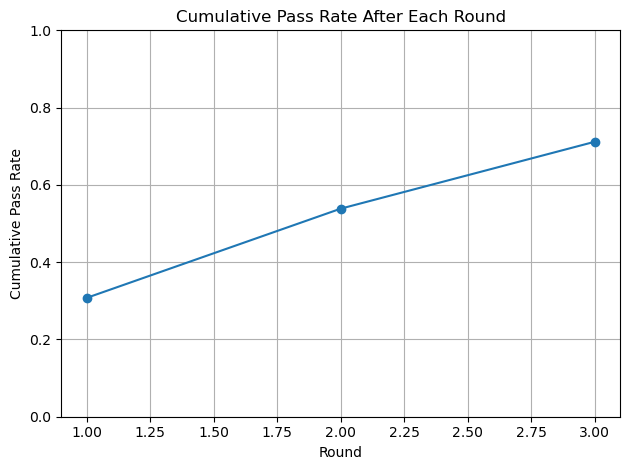

Verifier error counts:
  gosec: 67
  staticcheck: 33
  go build -race: 10
  govulncheck: 10
  errcheck: 22
  go-errorlint: 22


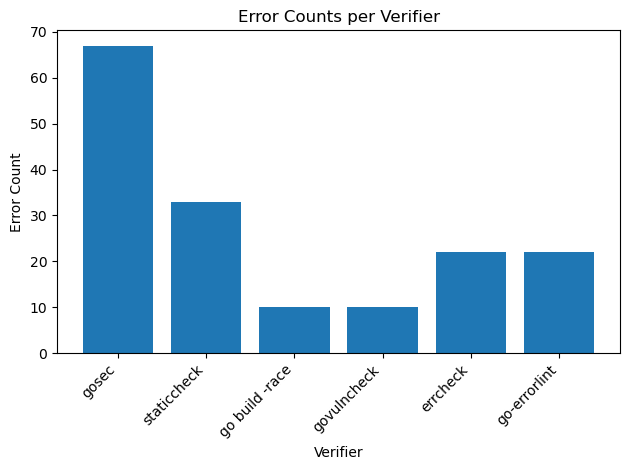

In [4]:
# ==== 使用说明 ====
# 1. 把下面的 folder_path 改成你的 .json 文件所在的目录
# 2. 运行本 cell，即可看到：
#    - 总任务数、通过任务数、总通过率
#    - 每轮之后的累计通过率折线图
#    - 每种 verifier 报错数量的柱状图

folder_path = "/home/fanbao/291P/go-code-generation-agency/benchmark/concurrency/results/gemini"  # TODO: 改成你的实际路径，例如 "benchmark/concurrency/results"

records = load_json_files(folder_path)

if not records:
    print("No valid JSON records found. Check folder_path.")
else:
    # 1. 总通过率（最终 pass）
    rate, passed, total = compute_overall_pass_rate(records)
    print(f"Total tasks: {total}")
    print(f"Passed tasks: {passed}")
    print(f"Overall pass rate: {rate:.2%}")
    
    # 2. 每轮之后的累计通过率折线图
    round_indices, cumulative_rates = compute_cumulative_pass_rate_by_round(records)
    if round_indices:
        print("Round indices:", round_indices)
        print("Cumulative pass rates:", [f"{r:.2%}" for r in cumulative_rates])
        plot_pass_rate_by_round(round_indices, cumulative_rates)
    
    # 3. 每种 verifier 报错数量柱状图
    verifier_counter = count_verifier_errors(records)
    print("Verifier error counts:")
    for v, c in verifier_counter.items():
        print(f"  {v}: {c}")
    plot_verifier_error_counts(verifier_counter)


Total tasks: 52
Passed tasks: 39
Overall pass rate: 75.00%
Round indices: [1, 2, 3]
Cumulative pass rates: ['32.69%', '59.62%', '75.00%']


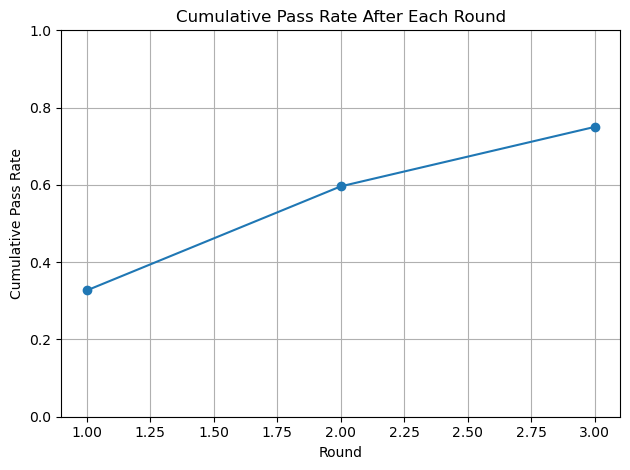

Verifier error counts:
  gosec: 56
  staticcheck: 47
  go build -race: 17
  govulncheck: 17
  errcheck: 28
  go-errorlint: 18


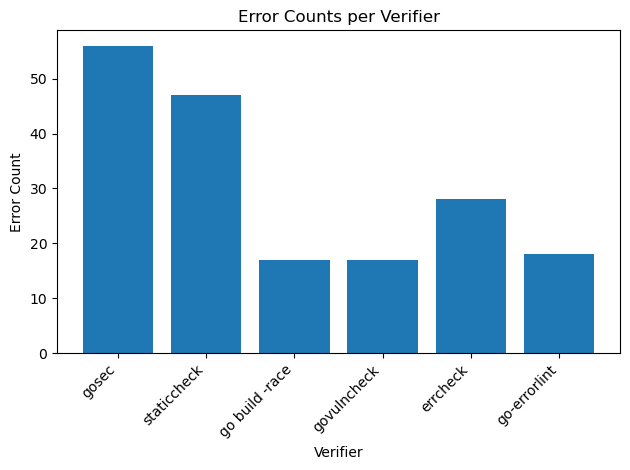

In [5]:
# ==== 使用说明 ====
# 1. 把下面的 folder_path 改成你的 .json 文件所在的目录
# 2. 运行本 cell，即可看到：
#    - 总任务数、通过任务数、总通过率
#    - 每轮之后的累计通过率折线图
#    - 每种 verifier 报错数量的柱状图

folder_path = "/home/fanbao/291P/go-code-generation-agency/benchmark/concurrency/results/openai"  # TODO: 改成你的实际路径，例如 "benchmark/concurrency/results"

records = load_json_files(folder_path)

if not records:
    print("No valid JSON records found. Check folder_path.")
else:
    # 1. 总通过率（最终 pass）
    rate, passed, total = compute_overall_pass_rate(records)
    print(f"Total tasks: {total}")
    print(f"Passed tasks: {passed}")
    print(f"Overall pass rate: {rate:.2%}")
    
    # 2. 每轮之后的累计通过率折线图
    round_indices, cumulative_rates = compute_cumulative_pass_rate_by_round(records)
    if round_indices:
        print("Round indices:", round_indices)
        print("Cumulative pass rates:", [f"{r:.2%}" for r in cumulative_rates])
        plot_pass_rate_by_round(round_indices, cumulative_rates)
    
    # 3. 每种 verifier 报错数量柱状图
    verifier_counter = count_verifier_errors(records)
    print("Verifier error counts:")
    for v, c in verifier_counter.items():
        print(f"  {v}: {c}")
    plot_verifier_error_counts(verifier_counter)


Total tasks: 52
Passed tasks: 48
Overall pass rate: 92.31%
Round indices: [1, 2, 3, 4, 5]
Cumulative pass rates: ['32.69%', '67.31%', '78.85%', '84.62%', '92.31%']


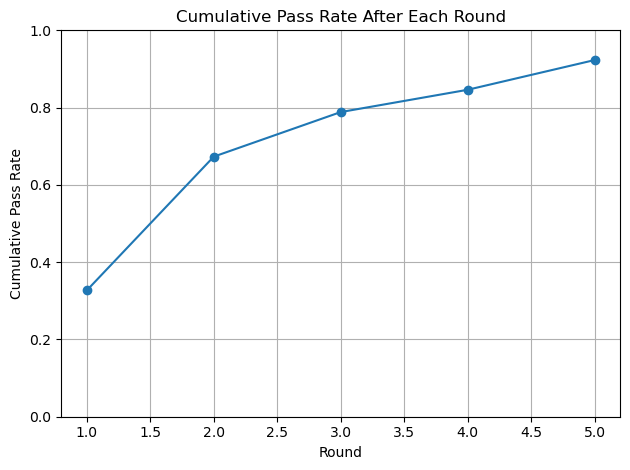

Verifier error counts:
  gosec: 70
  errcheck: 38
  staticcheck: 41
  go build -race: 24
  govulncheck: 24
  go-errorlint: 27


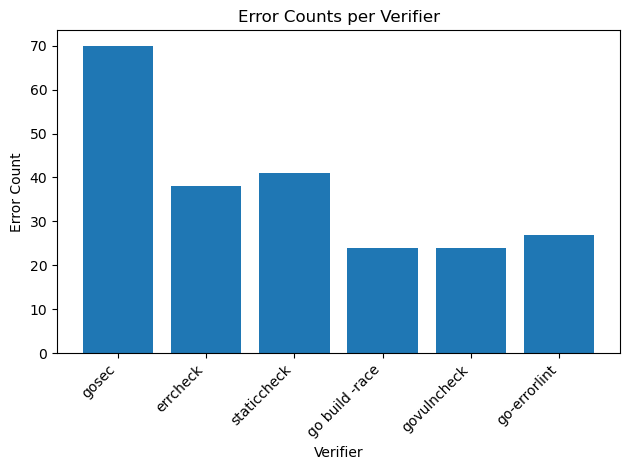

In [6]:
# ==== 使用说明 ====
# 1. 把下面的 folder_path 改成你的 .json 文件所在的目录
# 2. 运行本 cell，即可看到：
#    - 总任务数、通过任务数、总通过率
#    - 每轮之后的累计通过率折线图
#    - 每种 verifier 报错数量的柱状图

folder_path = "/home/fanbao/291P/go-code-generation-agency/benchmark/concurrency/results/anthropic"  # TODO: 改成你的实际路径，例如 "benchmark/concurrency/results"

records = load_json_files(folder_path)

if not records:
    print("No valid JSON records found. Check folder_path.")
else:
    # 1. 总通过率（最终 pass）
    rate, passed, total = compute_overall_pass_rate(records)
    print(f"Total tasks: {total}")
    print(f"Passed tasks: {passed}")
    print(f"Overall pass rate: {rate:.2%}")
    
    # 2. 每轮之后的累计通过率折线图
    round_indices, cumulative_rates = compute_cumulative_pass_rate_by_round(records)
    if round_indices:
        print("Round indices:", round_indices)
        print("Cumulative pass rates:", [f"{r:.2%}" for r in cumulative_rates])
        plot_pass_rate_by_round(round_indices, cumulative_rates)
    
    # 3. 每种 verifier 报错数量柱状图
    verifier_counter = count_verifier_errors(records)
    print("Verifier error counts:")
    for v, c in verifier_counter.items():
        print(f"  {v}: {c}")
    plot_verifier_error_counts(verifier_counter)


Total tasks: 19
Passed tasks: 9
Overall pass rate: 47.37%
Round indices: [1, 2, 3]
Cumulative pass rates: ['21.05%', '36.84%', '47.37%']


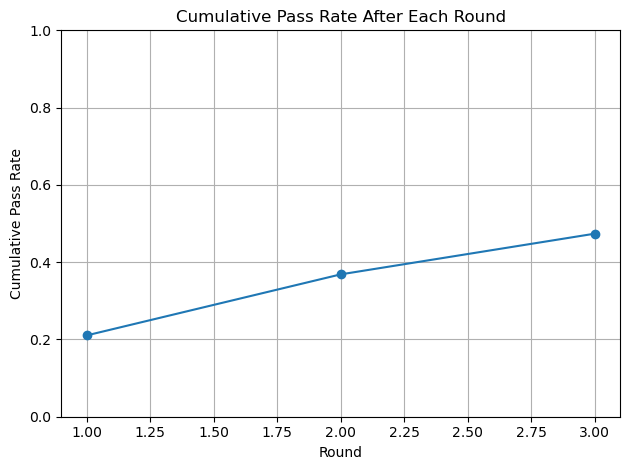

Verifier error counts:
  go build -race: 21
  gosec: 32
  govulncheck: 23
  errcheck: 23
  go-errorlint: 21
  staticcheck: 31


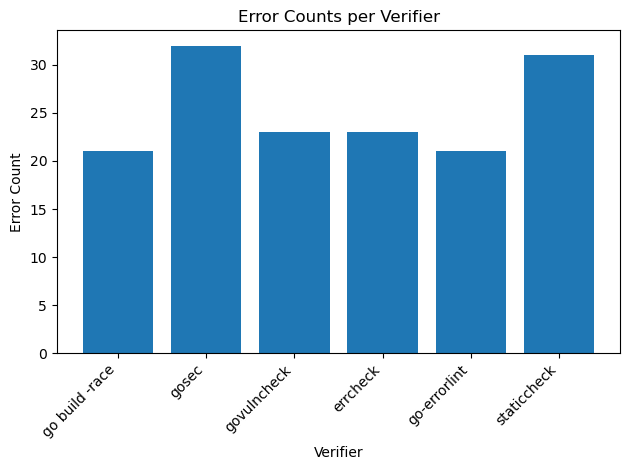

In [10]:
# ==== 使用说明 ====
# 1. 把下面的 folder_path 改成你的 .json 文件所在的目录
# 2. 运行本 cell，即可看到：
#    - 总任务数、通过任务数、总通过率
#    - 每轮之后的累计通过率折线图
#    - 每种 verifier 报错数量的柱状图

folder_path = "/home/fanbao/291P/go-code-generation-agency/benchmark/concurrency/results/meta"  # TODO: 改成你的实际路径，例如 "benchmark/concurrency/results"

records = load_json_files(folder_path)

if not records:
    print("No valid JSON records found. Check folder_path.")
else:
    # 1. 总通过率（最终 pass）
    rate, passed, total = compute_overall_pass_rate(records)
    print(f"Total tasks: {total}")
    print(f"Passed tasks: {passed}")
    print(f"Overall pass rate: {rate:.2%}")
    
    # 2. 每轮之后的累计通过率折线图
    round_indices, cumulative_rates = compute_cumulative_pass_rate_by_round(records)
    if round_indices:
        print("Round indices:", round_indices)
        print("Cumulative pass rates:", [f"{r:.2%}" for r in cumulative_rates])
        plot_pass_rate_by_round(round_indices, cumulative_rates)
    
    # 3. 每种 verifier 报错数量柱状图
    verifier_counter = count_verifier_errors(records)
    print("Verifier error counts:")
    for v, c in verifier_counter.items():
        print(f"  {v}: {c}")
    plot_verifier_error_counts(verifier_counter)


Total tasks: 70
Passed tasks: 60
Overall pass rate: 85.71%
Round indices: [1, 2, 3]
Cumulative pass rates: ['62.86%', '82.86%', '85.71%']


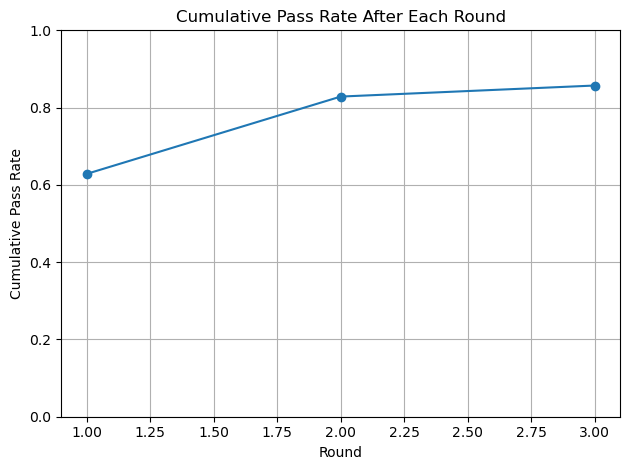

In [24]:
# ==== 使用说明 ====
# 1. 把下面的 folder_path 改成你的 .json 文件所在的目录
# 2. 运行本 cell，即可看到：
#    - 总任务数、通过任务数、总通过率
#    - 每轮之后的累计通过率折线图
#    - 每种 verifier 报错数量的柱状图

folder_path = "/home/fanbao/291P/go-code-generation-agency/benchmark/coding/results/openai"  # TODO: 改成你的实际路径，例如 "benchmark/concurrency/results"

records = load_json_files(folder_path)

if not records:
    print("No valid JSON records found. Check folder_path.")
else:
    # 1. 总通过率（最终 pass）
    rate, passed, total = compute_overall_pass_rate(records)
    print(f"Total tasks: {total}")
    print(f"Passed tasks: {passed}")
    print(f"Overall pass rate: {rate:.2%}")
    
    # 2. 每轮之后的累计通过率折线图
    round_indices, cumulative_rates = compute_cumulative_pass_rate_by_round(records)
    if round_indices:
        print("Round indices:", round_indices)
        print("Cumulative pass rates:", [f"{r:.2%}" for r in cumulative_rates])
        plot_pass_rate_by_round(round_indices, cumulative_rates)
